## $R$-learner baseline for IHDP
* Based on Robinson decomposition
* Tensorflow implementation
* Propensity score model based on MLP

In [1]:
import os
import sys
from time import time

import numpy as np
import tensorflow as tf

import pandas as pd
import math

import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement=True
sess = tf.Session(config=config)

In [2]:
class flags:
    
    # dim = 2
    
    x_dim = 25
    y_dim = 1
    t_dim = 2
    # M = 100
    M = 30
    
    # optimization
    learning_rate = 1e-3 # Base learning rate
    lr_decay = 0.999995 # Learning rate decay, applied every step of the optimization
    
    batch_size = 128 # Batch size during training per GPU
    hidden_size = 2
    
    
FLAGS = flags()
args = FLAGS

DTYPE = tf.float32

In [3]:
def int_shape(x):
    return list(map(int, x.get_shape()))

def print_shape(x,varname='variable'):
    if x is None:
        print('%s size: None' % (varname))
        return
    x_shape = x.shape.as_list()
    # print('%s size: [%d,%d,%d]' % (varname,x_shape[1],x_shape[2],x_shape[3]))
    print(varname,end=': ')
    print(x_shape)

def tf_eval(tf_tensor,n_samples,feed_dict=None):
    
    MLOOP = np.int(np.ceil(n_samples/FLAGS.batch_size))
    
    dd = tf_tensor.shape.as_list()[1:]
    dd.insert(0,n_samples)
    
    x = np.zeros(dd)
    
    for mloop in range(MLOOP):
        
        st = mloop*FLAGS.batch_size
        ed = min((mloop+1)*FLAGS.batch_size, n_samples)
        
        if feed_dict is not None:
            feed_dict_i = dict()
            for key in feed_dict.keys():
                feed_dict_i[key] = np.random.randn(*int_shape(key))
                feed_dict_i[key][:ed-st] = feed_dict[key][st:ed]
            y = sess.run(tf_tensor,feed_dict=feed_dict_i)
        else:
            y = sess.run(tf_tensor)
        
        # print([st,ed])
        x[st:ed] = y[:ed-st]
    
    return x

def tf_eval_list(tf_tensor_list,n_samples,feed_dict=None):
    
    if isinstance(tf_tensor_list, list)==False:
        print('Input not a list')
        return None
    
    MLOOP = np.int(np.ceil(n_samples/FLAGS.batch_size))
    
    res = dict()

    for key in tf_tensor_list:
        dd = key.shape.as_list()[1:]
        dd.insert(0,n_samples)
        res[key] = np.zeros(dd)
    
    for mloop in range(MLOOP):
        
        st = mloop*FLAGS.batch_size
        ed = min((mloop+1)*FLAGS.batch_size,n_samples)
        
        if feed_dict is not None:
            feed_dict_i = dict()
            for key in feed_dict.keys():
                feed_dict_i[key] = np.random.randn(*int_shape(key))
                feed_dict_i[key][:ed-st] = feed_dict[key][st:ed]
            # print(feed_dict_i)
            y = sess.run(tf_tensor_list,feed_dict=feed_dict_i)
        else:
            y = sess.run(tf_tensor_list)
        
        for i in range(len(tf_tensor_list)):
            res[tf_tensor_list[i]][st:ed] = y[i][:ed-st]
    
    return res

In [4]:
def simple_mlp(x,out_dim,name):
    
    hidden_units = 64   # size of hidden units in a layer
    
    input_tensor = x
    
    with tf.variable_scope('%s' % name,reuse=tf.AUTO_REUSE):
        h1 = tf.layers.dense(input_tensor,hidden_units,activation=tf.nn.relu)
        h2 = tf.layers.dense(h1,hidden_units,activation=tf.nn.relu)
        o = tf.layers.dense(h2,out_dim,activation=None)
        
    return o;

def linear_mdl(x,out_dim,name):
    
    with tf.variable_scope('%s' % name,reuse=tf.AUTO_REUSE):
        o = tf.layers.dense(x,out_dim,activation=None)
        
    return o;

In [5]:
def eval_pehe(tau_hat,tau):
    return np.sqrt(np.mean(np.square(tau-tau_hat)))

In [6]:
def onehot(t,dim):
    
    m_samples = t.shape[0]
    tt = np.zeros([m_samples,dim])
    
    for i in range(m_samples):
        tt[i,np.int(t[i])] = 1
        
    return tt

In [7]:
def load_ihdp(trial_id=0,filepath='./data/',istrain=True):
    
    if istrain:
        data_file = filepath+'ihdp_npci_1-1000.train.npz'
    else:
        data_file = filepath+'ihdp_npci_1-1000.test.npz'
        
    data = np.load(data_file)
    
    x = data['x'][:,:,trial_id]
    y = data['yf'][:,trial_id]
    t = data['t'][:,trial_id]
    ycf = data['ycf'][:,trial_id]
    mu0 = data['mu0'][:,trial_id]
    mu1 = data['mu1'][:,trial_id]
    
    return x,y,t,ycf,mu0,mu1

In [8]:
data = np.load('../ihdp_example.npy',allow_pickle=True).item()
X = data['X'] # Confounder proxiess
Y = data['Y'] # Factual outcomes
T = data['T'] # Treatment
Tau = data['Tau']  # Ground truth ITE

n_samples = X.shape[0]

### Model specification

In [ ]:
input_x = tf.placeholder(tf.float32, shape=[FLAGS.batch_size, FLAGS.x_dim])
input_t = tf.placeholder(tf.int32, shape=[FLAGS.batch_size, FLAGS.t_dim])
input_y = tf.placeholder(tf.float32, shape=[FLAGS.batch_size, FLAGS.y_dim])

m_x = linear_mdl(input_x, 1, 'm') # expected outcome 
logit_t_x = linear_mdl(input_x, 2, 'ps') # propensity score
tau_x = linear_mdl(input_x, 1, 'tau') # causal effect

e_x = tf.reshape(tf.nn.softmax(logit_t_x)[:,1],[FLAGS.batch_size,1])

loss_e_vec = tf.nn.softmax_cross_entropy_with_logits(labels=input_t, logits=logit_t_x)
loss_e = tf.reduce_mean(loss_e_vec)

input_t_bin = tf.reshape(tf.cast(input_t[:,1],dtype=tf.float32),[FLAGS.batch_size,1])
r_res = (input_y - m_x) - (tf.cast(input_t_bin, dtype=tf.float32) - e_x) * tau_x

loss_r = tf.reduce_mean(tf.square(r_res))
loss_m = tf.reduce_mean(tf.square(input_y - m_x))

In [12]:
m_vars = [v for v in tf.get_collection(
    tf.GraphKeys.TRAINABLE_VARIABLES) if v.name.startswith('m')]
tau_vars = [v for v in tf.get_collection(
    tf.GraphKeys.TRAINABLE_VARIABLES) if v.name.startswith('tau')]
ps_vars = [v for v in tf.get_collection(
    tf.GraphKeys.TRAINABLE_VARIABLES) if v.name.startswith('ps')]

learning_rate = tf.placeholder(tf.float32)

train_m = tf.train.AdamOptimizer(learning_rate).minimize(loss_m, var_list=m_vars)
train_ps = tf.train.AdamOptimizer(learning_rate).minimize(loss_e, var_list=ps_vars)
train_tau = tf.train.AdamOptimizer(learning_rate).minimize(loss_r, var_list=tau_vars)
train_all = tf.train.AdamOptimizer(learning_rate).minimize(loss_r)

### Training

In [ ]:
def estimate_causal_effect(xx, n_runs=1):

    m_samples = xx.shape[0]

    t0 = np.zeros([m_samples,FLAGS.t_dim]); t0[:,0] = 1;
    t1 = np.zeros([m_samples,FLAGS.t_dim]); t1[:,1] = 1;
    mu0_hat = estimate_outcome(xx, t0, n_runs)
    mu1_hat = estimate_outcome(xx, t1, n_runs)

    tau_hat = mu1_hat - mu0_hat

    return tau_hat

In [13]:
def check_results(x_x,t_x,y_x,tau_x,msg=''):
    
    tau_hat = estimate_causal_effect(x_x).reshape([-1,])    
    pehe_mkl = eval_pehe(tau_hat, tau_x)*y_std
    corr_ = np.corrcoef(tau_hat.reshape([-1,]),tau_x.reshape([-1,]))[0,1]
    err_ = np.mean(tau_hat)-4  
    
    Y_mdl = estimate_outcome(x_x,t_x)
    rmse_ = eval_y_rmse(y_x, Y_mdl)

    
    print('%sPEHE=%.2f, CORR=%.2f, ERR=%.2f, RMSE=%.2f' % (msg, pehe_mkl, corr_, err_, rmse_) )
    
    return [pehe_mkl, corr_, err_, rmse_]


def eval_y_rmse(yy,yy_mdl):
    
    yy_mdl_mean = np.mean(yy_mdl,axis=1).reshape([-1,1])
    
    rmse = np.sqrt(np.mean(np.square(yy-yy_mdl_mean)))
    
    return rmse


In [14]:
# Initialization

initializer = tf.global_variables_initializer()
sess.run(initializer)

In [ ]:
# Training nuisance models (mean outcome m(x), propensity score e(x))

lr = 1e-3

max_epoch = 10
updates_per_epoch = 100

epoch_record = np.zeros([max_epoch,])

for epoch_id in range(max_epoch):
    
    loss_record = np.zeros([updates_per_epoch,])
    
    t0 = time()
    
    for step in range(updates_per_epoch):

        
        ind = np.random.choice(n_samples,FLAGS.batch_size)
        
        feed_dict = {learning_rate:lr}
        feed_dict[input_x] = X[ind]
        feed_dict[input_y] = Y[ind]
        feed_dict[input_t] = T[ind]
        
        _,_,loss_m_val,loss_e_val = sess.run([train_m, train_ps, loss_m, loss_e], feed_dict)
        loss_record[step] = loss_m_val+loss_e_val
        
    
    t1 = time()
    
    print([epoch_id+1,np.mean(loss_record),t1-t0])
    epoch_record[epoch_id] = np.mean(loss_record)
    
_ = plt.plot(epoch_record)

[1, 2.003913413286209, 0.08022618293762207]
[2, 2.176656974554062, 0.07653498649597168]
[3, 2.0134959912300108, 0.07185602188110352]
[4, 2.063565641641617, 0.07367277145385742]
[5, 2.0994693446159363, 0.07602810859680176]
[6, 2.0388131403923033, 0.07746529579162598]
[7, 2.1118886005878448, 0.0758676528930664]
[8, 1.9602853214740754, 0.0740659236907959]
[9, 2.0534018802642824, 0.07711386680603027]
[10, 1.9967964005470276, 0.0876460075378418]


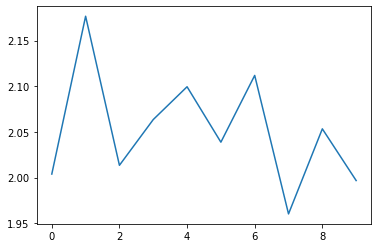

In [22]:
# Training causal effect model (\tau(x))

lr = 1e-3

max_epoch = 10
updates_per_epoch = 100

epoch_record = np.zeros([max_epoch,])

for epoch_id in range(max_epoch):
    
    loss_record = np.zeros([updates_per_epoch,])
    
    t0 = time()
    
    for step in range(updates_per_epoch):

        # n_samples
        ind = np.random.choice(n_samples,FLAGS.batch_size)
        # ind
        feed_dict = {learning_rate:lr}
        feed_dict[input_x] = X[ind]
        feed_dict[input_y] = Y[ind]
        feed_dict[input_t] = T[ind]
        
        _,loss_tau_val = sess.run([train_tau, loss_r], feed_dict)
        loss_record[step] = loss_tau_val
    
    t1 = time()
    
    print([epoch_id+1,np.mean(loss_record),t1-t0])
    epoch_record[epoch_id] = np.mean(loss_record)
    
_ = plt.plot(epoch_record)

### Evaluation

In [23]:
tau_hat = tf_eval(tau_x, n_samples, {input_x: X})

pehe_ls = eval_pehe(tau_hat, Tau)

print(pehe_ls)

2.8208042070798784


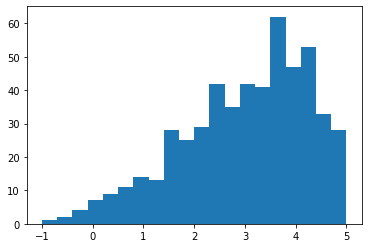

In [29]:
_ = plt.hist(tau_hat,bins=20,range=[-1,5])

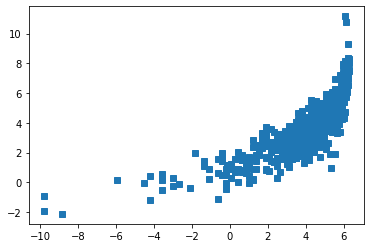

In [28]:
_ = plt.plot(Tau,tau_hat,'s')

In [30]:
m_x_hat = tf_eval(m_x, n_samples, {input_x: X})
e_x_hat = tf_eval(e_x, n_samples, {input_x: X})

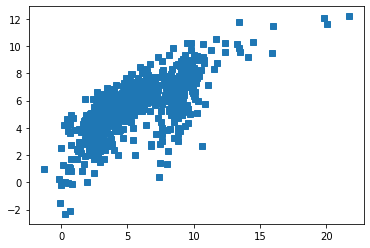

In [31]:
_ = plt.plot(Y, m_x_hat,'s')

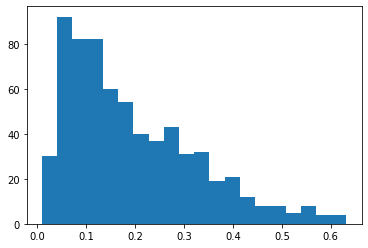

In [32]:
_ = plt.hist(e_x_hat,bins=20)